In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import random

from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import gym
from gym.spaces import Discrete, Tuple

from env_mp_1 import MetaGames
from rmax_1 import RmaxAgent, Memory

def discretize(number, radius):
    #return (torch.round(torch.div(number, radius))) * radius
    #change made: originally: [0,3,6,9], now: [0,1,2,3]
    return torch.round(torch.div(number, radius))


In [2]:
inner_gamma = 0.9         #inner game discount factor
meta_gamma = 0.9          #meta game discount factor
meta_alpha = 0.4          #meta game learning rate
R_max = 0.98
max_meta_epi = 500
max_meta_steps = 100

epsilon = 0.2
radius = 3                #radius for discretization, assuming radius>1

#reward tensor for plotting purposes [episode, step, agents]
plot_rew = torch.zeros(max_meta_epi, max_meta_steps, 2).to(device)    

# creating environment
env = MetaGames("NL", "IPD")

memory = Memory()
rmax = RmaxAgent(env, R_max, meta_gamma, inner_gamma, radius, epsilon)

In [24]:
for episode in tqdm(range(max_meta_epi)): #for each meta-episode
    #initialise meta-state and meta-action randomly
    meta_s = rmax.index_to_table(env, random.randint(0, rmax.meta_size * env.num_agents), env.num_agents)
    memory.states.append(meta_s) 
    
    for step in range(max_meta_steps):    #for each meta time step
        #previous meta-state set as the policy of the next game
        env.innerq = meta_s.detach().clone() #
        #--------------------------------------START OF INNER GAME--------------------------------------
        #reset environment 
        env.reset()   

        #select inner-action with epsilon greedy 
        best_action = env.select_action().detach().clone()      

        #run inner game according to best_action
        reward, info = env.step(best_action)  

        #update inner r matrix [agent, action]
        env.innerr[0, int(best_action[0])] = reward.detach().clone() 
        env.innerr[1, int(best_action[1])] = info.detach().clone()

        #---------------------------------------END OF INNER GAME--------------------------------------
        #save reward, info for plotting              
        plot_rew[episode,step,0] += reward.detach().clone()
        plot_rew[episode,step,1] += info.detach().clone()
        
        #meta-action = inner game Q table of our agent
        meta_a = env.innerq[0, :].detach().clone()
        memory.actions.append(meta_a) 
        
        #Compute new inner Q table, our agent: by Q learning, oppo: max of Q table by putting in previous meta-s
        env.innerq[0, :] = meta_alpha * env.innerq[0, :] + (1 - meta_alpha) * env.innerq[0, :]
        
        stateind_arr = [i for i,x in enumerate(rmax.Q.get("state")) if x == rmax.find_meta_index(torch.flatten(meta_s))]  
        if len(stateind_arr) == 0:        #if we haven't visited that meta_s before & no record, 
            #we put random meta_action as inner Q
            env.innerq[1, :] = rmax.index_to_table(env, random.randint(0, rmax.meta_size), 1)  
        else:                             #else if we visited that meta_s before
            #inner Q is the action that corresponds to max Q(meta_s)
            env.innerq[1, :] = rmax.index_to_table(env, int(np.max([rmax.Q.get("state")[i] for i in stateind_arr])), 1)    
        
        #meta-state = discretized inner game Q table of all agents
        new_meta_s = discretize(env.innerq.detach().clone(), radius)
        memory.states.append(new_meta_s)    
        
        #meta-reward = sum of rewards of our agent in inner game of K episodes & T timesteps
        our_REW = reward.detach().clone()                
        memory.rewards.append(reward)
        
        #rmax update step
        rmax.update(env, memory, meta_s, meta_a, new_meta_s)

        #prepare meta_s for next step
        meta_s = new_meta_s.detach().clone()


  0%|                                                                      | 0/500 [00:00<?, ?it/s]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/data/engs-oxfair3/kittymfos/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_387114/1640225908.py", line 53, in <module>
    rmax.update(env, memory, meta_s, meta_a, new_meta_s)
  File "/home/magd5245/Desktop/Work/Dictionaryver/rmax_1.py", line 104, in update
KeyError: 32

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/data/engs-oxfair3/kittymfos/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2052, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/data/engs-oxfair3/kittymfos/lib/python3.8/site-packages/IPython/core/ultratb.py", line 1112, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/data/engs-oxfair3/kittymfos/lib/python3.8/site-packages/IPython/core/ultratb.py", line 1006, in structur

In [25]:
meta_s, meta_a, new_meta_s

(tensor([[6., 3.],
         [3., 0.]]),
 tensor([6., 3.]),
 tensor([[2., 1.],
         [4., 1.]]))

In [ ]:
state_mapped = self.find_meta_index( torch.flatten(state))
action_mapped = self.find_meta_index( torch.flatten(action))
next_state_mapped = self.find_meta_index( torch.flatten(next_state))

pair_index = self.find_pair_index([state_mapped, action_mapped], self.nSA)
pairs_index = self.find_pair_index([state_mapped, action_mapped, next_state_mapped], self.nSAS)

if self.nSA[state_mapped][action_mapped] < self.m:
    #update nSA dictionary 
    self.nSA.get("state").append(state_mapped)
    self.nSA.get("action").append(action_mapped)
    self.nSA.get("nval").append(self.nSA.get("nval")[pair_index] + 1)
    #update R dictionary          
    self.R.get("state").append(state_mapped)
    self.R.get("action").append(action_mapped)
    self.R.get("Rval").append(self.R.get("Rval")[pair_index] + memory.rewards[-1])  
    #update nSAS dictionary
    self.nSAS.get("state").append(state_mapped)
    self.nSAS.get("action").append(action_mapped)
    self.nSAS.get("next_state").append(next_state_mapped)
    self.nSAS.get("nvals").append(self.nSAS.get("nvals")[pairs_index] + 1)

    if self.nSA.get("nval")[pair_index] == self.m:

        for mval in range(self.m):

            for s in range(self.meta_size * 2):

                for a in range(self.meta_size):
                    #find indices that have been visited for at least m times
                    bigger_m_ind = [i for i,x in enumerate(len(self.nSA.get("nval"))) if x >= self.m]

                    for ind in bigger_m_ind:   
                        q = (self.R.get("Rval")[ind] / self.nSA.get("nval")[ind])

                        for next_s in range(env.d * 2):
                            transition = self.nSAS.get("nvals")[ind] / self.nSA.get("nval")[ind]
                            #find state indices that corresponds to next_s
                            stateind_arr = [i for i,x in enumerate(self.nSA.get("states")) if x == next_s]

                            #if there are Q values that are larger than R_max / (1 - meta_gamma)
                            if np.max([self.Q.get("Qval")[states] for states in range(stateind_arr)]) > self.Q0:
                                q += transition * np.max([self.Q.get("Qval")[states] for states in range(stateind_arr)])
                            #else we use the explore Q value
                            else:
                                q += self.Q0

                        #update Q dicitonary
                        Q_pair_index = self.find_pair_index([s, a], self.nSA)  
                        self.Q.get("state").append(s)
                        self.Q.get("action").append(a)
                        self.Q.get("Qval")[Q_pair_index] = q 

    else:
        #update Q dicitonary
        self.Q.get("state").append(s)
        self.Q.get("action").append(a)
        self.Q.get("Qval")[pair_index] = self.Q0



In [26]:
self = rmax

Average reward of our agent: tensor(0.4034, device='cuda:0')
Average reward of another agent: tensor(0.5966, device='cuda:0')


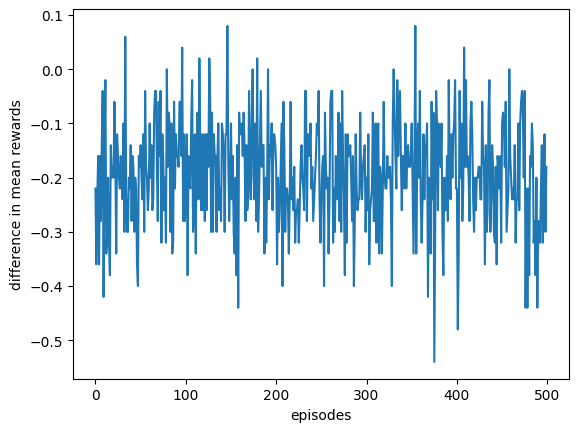

In [5]:
plot_rew_mean_diff = torch.mean(plot_rew[:,:,0],1) - torch.mean(plot_rew[:,:,1],1)
fig_handle = plt.plot(plot_rew_mean_diff.cpu().numpy())

plt.xlabel("episodes")
plt.ylabel("difference in mean rewards")

print("Average reward of our agent:", torch.mean(plot_rew[:,:,0],(0,1)))
print("Average reward of another agent:", torch.mean(plot_rew[:,:,1],(0,1)))

#plt.savefig('radius' + str(radius) + '_' + str(max_meta_epi) + '_' + str(max_meta_steps) + '_pd.png')

In [7]:
test= [1,73,4,5,2]
arrr = test[0,1,3]

TypeError: list indices must be integers or slices, not tuple

In [26]:
arrr

0

# OLD VERSION (PLS DELETE IF ABOVE WORKS)

In [ ]:
for episode in tqdm(range(max_meta_epi)): #for each meta-episode
    #initialise meta-state and meta-action as zeros
    meta_s = torch.zeros(env.b, env.num_actions, env.num_agents).to(device) 
    memory.states.append(meta_s)
    meta_a = torch.zeros(env.b, env.num_actions).to(device) 
    memory.actions.append(meta_a)    
    
    for step in range(max_meta_steps):    #for each meta time step
        env.innerq = meta_s.detach().clone()    #previous meta-state set as the policy of the next game
        
#--------------------------------------INNER GAME--------------------------------------
        for epi in range(max_inner_epi):              #for each inner episodes 
            #print("inner episode =", epi, meta_s)
            #state = env.reset()   #reset environment 
            env.reset()   #reset environment 
            
            for t in range(max_inner_steps):                     #for each inner timestep
                #print("inner timestep =", t)
                if epi == 0 & t == 0:
                    #initialised action 
                    best_action = env.init_action.detach().clone()
                else:
                    #find action that has max Q value for current state for both agents
                    best_action = env.choose_action()

                #run inner game according to that action, for K episodes & T timesteps, output used to be new_state, reward, done, _ 
                reward, info = env.step(best_action)  
                
                #update inner r matrix
                for i in range(env.b):
                    #env.innerr[i, state[i], best_action[0,i], 0] = reward[i] 
                    #env.innerr[i, state[i], best_action[1,i], 1] = info[i]
                    env.innerr[i, best_action[0,i], 0] = reward[i].detach().clone() 
                    env.innerr[i, best_action[1,i], 1] = info[i].detach().clone()

                    
                #update inner q matrix, another for loop since have to wait till inner r matrix gets updated    
                for i in range(env.b):    
                    #env.innerq[i, state[i], best_action[0,i], 0] = env.innerr[i, state[i], best_action[0,i], 0] + inner_gamma * torch.max(env.innerq[i, newstate[i], :, 0]) 
                    #env.innerq[i, state[i], best_action[1,i], 1] = env.innerr[i, state[i], best_action[1,i], 1] + inner_gamma * torch.max(env.innerq[i, newstate[i], :, 1])
                    env.innerq[i, best_action[0,i], 0] = env.innerr[i, best_action[0,i], 0].detach().clone() + inner_gamma * torch.max(env.innerq[i, :, 0]).detach().clone()
                    env.innerq[i, best_action[1,i], 1] = env.innerr[i, best_action[1,i], 1].detach().clone() + inner_gamma * torch.max(env.innerq[i, :, 1]).detach().clone()
                #set current state = new state
                #state = newstate  
                
                #save reward, info for plotting              
                plot_rew[episode,step,0,:] += reward.detach().clone()
                plot_rew[episode,step,1,:] += info.detach().clone()
        
        #meta-state = inner game Q table for all agents
        new_meta_s = discretize(env.innerq.detach().clone(), radius)
        #meta-action = inner game Q table for our agent
#       new_meta_a = discretize(env.innerq[:,:,0].detach().clone(), radius)     
        new_meta_a = rmax.select_action(new_meta_s)
         
        our_REW = reward.detach().clone()                #meta-reward = sum of rewards of our agent in inner game of K episodes & T timesteps
        memory.rewards.append(reward)
        #print("meta step=", step, meta_s, meta_a, new_meta_s)
        rmax.update(env, memory, meta_s, meta_a, new_meta_s)
        
        meta_s = new_meta_s
        meta_a = new_meta_a

        
